In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from models.nets import MLP
import pylab as pl
import wandb

from utils.train import basic_train

In [14]:
net = MLP.MLP(1, 1, hidden_size=64, mlp_blocks=3, dropout=0, skip=False, activation=nn.GELU())
x = torch.randn((10, 1))

In [20]:
from torch import autograd
import numpy as np


gradient = autograd.functional.vjp(net, x, torch.ones_like(x), create_graph=False)

RuntimeError: The Tensor returned by the function given to hvp should contain a single element

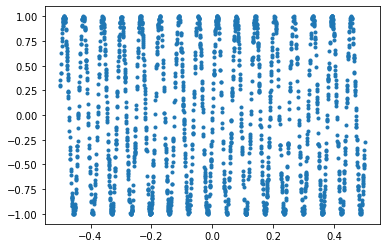

In [49]:
# Generate data
def f(x):
    return torch.sin(100*x)# + 0.1*torch.randn((N, ))
N = 2048
x = torch.rand((N, )) - 0.5
y = f(x)
x_test = 2 * x
y_test = f(x_test)

pl.plot(x, y, '.')
pl.show()

In [ ]:
def train():
    with wandb.init(project="NN-tests", entity="lettera") as run:
        config = wandb.config
        print(config)
        net = MLP.MLP(1, 1, hidden_size=config["hidden_size"], mlp_blocks=config["skip_mlps"], dropout=config["dropout"], skip=True, activation=nn.ReLU())
        net.train()
        optimizer = torch.optim.Adam(net.parameters(), config["learning_rate"], weight_decay=config["weight_decay"])
        criterion = nn.MSELoss()
        for epoch in range(300):
            y_pred = net(x.view(-1, 1))
            loss = criterion(y_pred.ravel(), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            wandb.log({"loss": loss, "epoch": epoch})
        
        with torch.no_grad():
            net.eval()
            y_pred = net(x_test.view(-1, 1))
            loss = criterion(y_pred.ravel(), y_test)
            wandb.log({"eval_loss": loss})

count = 50 # number of runs to execute
wandb.agent("lettera/NN-tests/map2sfmv", function=train, count=count)

In [147]:
%matplotlib inline

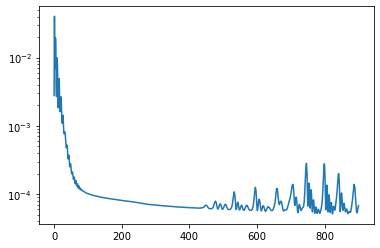

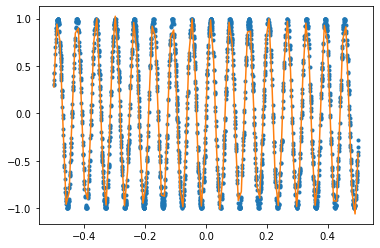

In [150]:
# Train loop
from IPython.display import clear_output
#net = MLP.MLP(1, 1, hidden_size=64, mlp_blocks=5, dropout=0, skip=False)

optimizer = torch.optim.Adam(net.parameters(), 1e-4)
criterion = nn.MSELoss()
losses = []
epochs = 1000
for epoch in range(epochs):
    net.train()
    y_pred = net(x.view(-1, 1))
    loss = criterion(y_pred.ravel(), y)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        net.eval()
        clear_output(True)
        pl.plot(losses)
        pl.yscale("log")
        pl.show()
        pl.plot(x, y, '.')
        t = torch.linspace(-0.5, 0.5, 100)
        pl.plot(t, net(t.view(-1, 1)).ravel().detach())
        pl.show()
        

In [156]:
from sklearn.decomposition import PCA

t = torch.linspace(-0.5, 0.5, 1024).view(-1, 1)
for i, module in enumerate(net.children()):
    t = module(t)
    print(t.shape)
    if min(t.shape) < 8:
        continue
    pca = PCA(n_components=8).fit(t.detach().cpu().numpy())

    print(pca.explained_variance_ratio_)

torch.Size([1024, 64])
[1.0000001e+00 2.8343305e-13 4.9636120e-16 3.5428095e-16 3.2780270e-16
 3.0503411e-16 2.4424145e-16 1.9550285e-16]
torch.Size([1024, 64])
[0.23279816 0.18557577 0.11222894 0.06930929 0.06350964 0.0538145
 0.0439719  0.03684652]
torch.Size([1024, 1])


In [108]:
%matplotlib qt

In [146]:
net.eval()
pl.plot(x, y, '.')
t = torch.linspace(-0.5, 0.5, 4096)
pl.plot(t, net(t.view(-1, 1)).ravel().detach())
pl.show()